In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

print("TF version:", tf.__version__)
print("TFP version:", tfp.__version__)

TF version: 2.3.0
TFP version: 0.11.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Bijectors

In [3]:
# Define base distribution

normal = tfd.Normal(loc = 2.0, scale=5.0)

In [4]:
# Sample from base distribution

n = 10000
z = normal.sample(n)

### Scale and shift bijector

In [5]:
# Define scale and shift

scale = 0.5
shift = 0.3

In [6]:
# Define chain bijector

scale_n_shift_v1 = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])

In [7]:
# We can also use call methods

scale_transf = tfb.Scale(scale)
shift_transf = tfb.Shift(shift)

scale_n_shift_v2 = shift_transf(scale_transf)

In [8]:
# Apply the forward transformation

x_0 = tf.add(tf.multiply(scale, z), shift)
x_1 = scale_n_shift_v1.forward(z)
x_2 = scale_n_shift_v2.forward(z)

In [9]:
# Check the forward transformation

tf.norm(x_0 - x_1), tf.norm(x_0 - x_2), tf.norm(x_1 - x_2)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

#### Plots

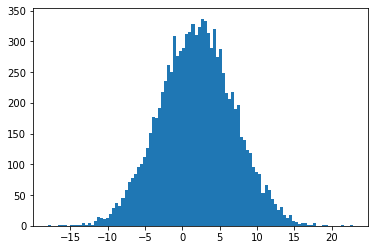

In [10]:
# Plot z density

plt.hist(z, bins=100)
plt.show()

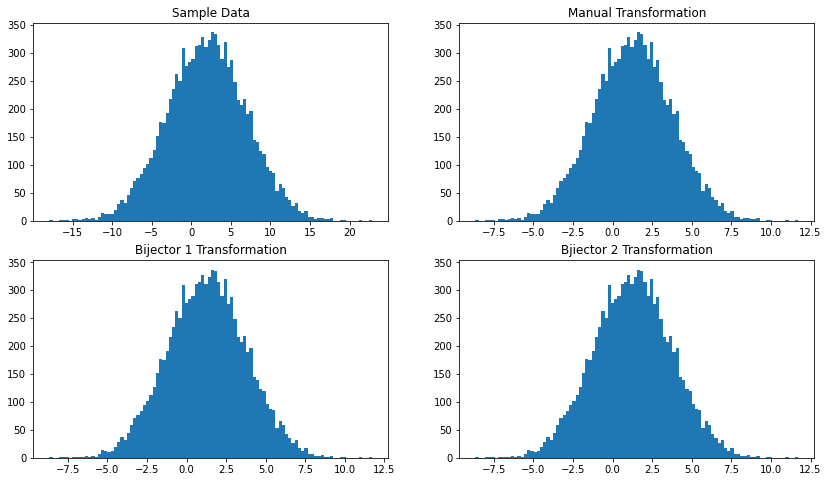

In [11]:
# Plot x density

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.hist(z, bins=100)
plt.title("Sample Data")

plt.subplot(2, 2, 2)
plt.hist(x_0, bins=100)
plt.title("Manual Transformation")

plt.subplot(2, 2, 3)
plt.hist(x_1, bins=100)
plt.title("Bijector 1 Transformation")

plt.subplot(2, 2, 4)
plt.hist(x_0, bins=100)
plt.title("Bjiector 2 Transformation")

plt.show()

#### Inverse transformation

In [12]:
# Apply inverse transformation

inv_x_0 = tf.divide(tf.subtract(x_0, shift), scale)
inv_x_1 = scale_n_shift_v1.inverse(x_1)
inv_x_2 = scale_n_shift_v2.inverse(x_2)

In [13]:
# Check inverse transformation

tf.norm(z - inv_x_0), tf.norm(z - inv_x_1), tf.norm(z - inv_x_2),

(<tf.Tensor: shape=(), dtype=float32, numpy=8.3036775e-06>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

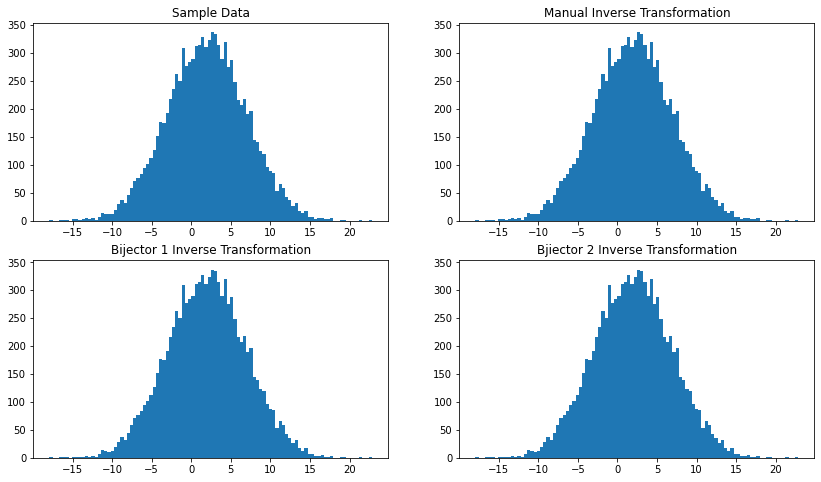

In [14]:
# Plot x inverse density

plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
plt.hist(z, bins=100)
plt.title("Sample Data")

plt.subplot(2, 2, 2)
plt.hist(inv_x_0, bins=100)
plt.title("Manual Inverse Transformation")

plt.subplot(2, 2, 3)
plt.hist(inv_x_1, bins=100)
plt.title("Bijector 1 Inverse Transformation")

plt.subplot(2, 2, 4)
plt.hist(inv_x_2, bins=100)
plt.title("Bjiector 2 Inverse Transformation")

plt.show()

#### Log probability

In [15]:
# Compute log prob for x

log_prob_x = normal.log_prob(z) - scale_n_shift_v1.forward_log_det_jacobian(z, event_ndims=0)
print(log_prob_x)

tf.Tensor([-3.5186057 -2.0345168 -3.1199598 ... -1.9683771 -1.9033237 -2.061459 ], shape=(10000,), dtype=float32)


In [16]:
# We can also use the inverse transformation

log_prob_x = normal.log_prob(scale_n_shift_v1.inverse(x_1)) + scale_n_shift_v1.inverse_log_det_jacobian(x_1, event_ndims=0)
print(log_prob_x)

tf.Tensor([-3.5186057 -2.0345168 -3.1199598 ... -1.9683771 -1.9033237 -2.061459 ], shape=(10000,), dtype=float32)


### Broadcasting

In [17]:
x = tf.random.normal(shape=(100, 1))

In [18]:
# Softfloor bijector

softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x_1)

y.shape

TensorShape([10000])

In [19]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.01, 0.02])
y = softfloor.forward(tf.reshape(x_1, (-1, 1)))

y.shape

TensorShape([10000, 2])

In [20]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.01, 0.02, 5, 1000])
y = softfloor.forward(tf.reshape(x_1, (-1, 1)))

y.shape

TensorShape([10000, 4])

In [21]:
# Plot routine

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

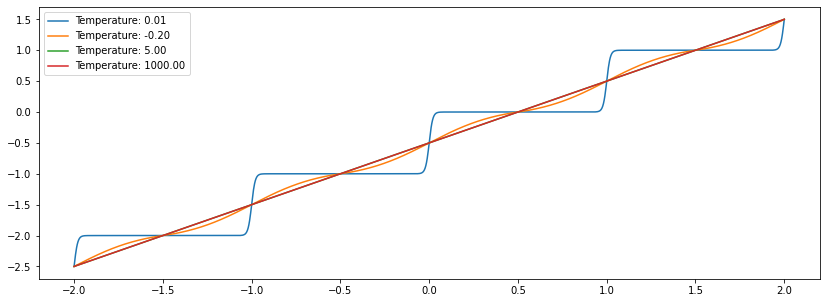

In [22]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]

softfloor = tfb.Softfloor(temperature=[0.01, -0.2, 5, 1000])
_plot(4, softfloor, ["temperature"], x)

In [23]:
# Gumbel bijector using broadcasting

n = 5
gumbel = tfb.GumbelCDF(loc = np.random.randint(-5, 5, n).astype(np.float32), 
                       scale = np.random.randint(0, 100, n).astype(np.float32))

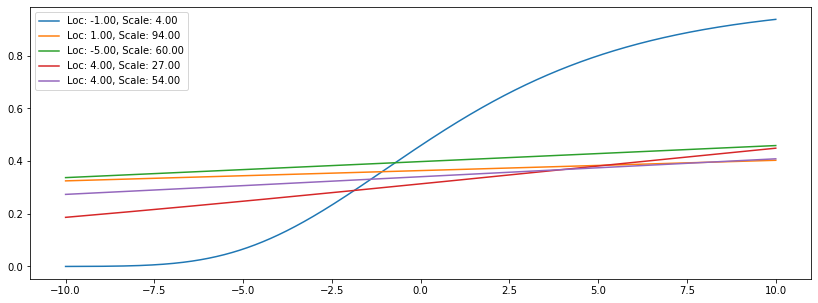

In [24]:
# Plot

x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]

_plot(n, gumbel, ["loc", "scale"], x)

In [25]:
# Gumbel bijector using broadcasting

n = 5

kswamy = tfb.KumaraswamyCDF(concentration0=np.random.normal(1, 1, n).astype(np.float32), 
                            concentration1=np.random.normal(1, 1, n).astype(np.float32))

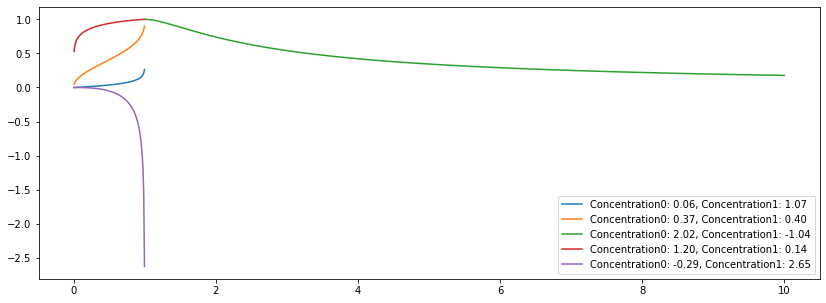

In [26]:
# Plot

x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]

_plot(n, kswamy, ["concentration0", "concentration1"], x)


***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [27]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [28]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [29]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [30]:
# Exponential bijector

exp = tfb.Exp()

In [31]:
# Log normal transformed distribution using exp and normal bijectors

log_normal_td = exp(normal)
print(log_normal_td)

log_normal_td = tfd.TransformedDistribution(normal, exp)
print(log_normal_td)

tfp.distributions.TransformedDistribution("expNormal", batch_shape=[], event_shape=[], dtype=float32)
tfp.distributions.TransformedDistribution("expNormal", batch_shape=[], event_shape=[], dtype=float32)


In [32]:
# Base distribution

n = 10000

z = normal.sample(n)

#### Plots

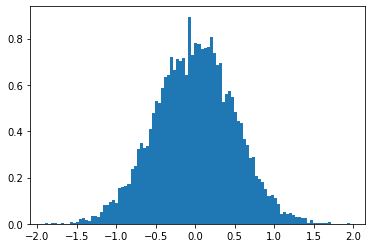

In [33]:
# Plot z density

plt.hist(z, bins=100, density=True)
plt.show()

In [34]:
# Transformed distribution

x = log_normal_td.sample(n)

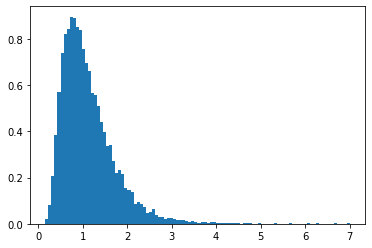

In [35]:
# Plot x density

plt.hist(x, bins=100, density=True)
plt.show()

In [36]:
# Define log normal distribution

log_normal = tfd.LogNormal(loc=loc, scale=scale)

In [37]:
# Sample log_normal

l = log_normal.sample(n)

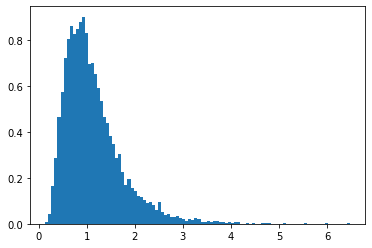

In [38]:
# Plot l density

plt.hist(l, bins=100, density=True)
plt.show()

#### Log probability

In [39]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [40]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(x)

In [41]:
# Check log probs

tf.norm(log_prob - log_prob_td)

<tf.Tensor: shape=(), dtype=float32, numpy=6.8162835e-06>

### Event shape and batch shape

In [42]:
# Normal distribution

loc = 0
scale = 1.0

normal = tfd.Normal(loc=loc, scale=scale)

In [43]:
# Set a scaling lower triangular matrix

tril = tf.random.normal(shape=(2, 4, 4))
scale_low_tril = tf.linalg.LinearOperatorLowerTriangular(tril)

In [44]:
# View of scale_low_tri

scale_low_tril.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 0.4671917 ,  0.        ,  0.        ,  0.        ],
        [-0.15255624, -0.82167655,  0.        ,  0.        ],
        [ 0.54505086, -0.31831515, -0.9261054 ,  0.        ],
        [ 1.2315443 , -0.7372966 ,  0.05808139,  1.2473693 ]],

       [[ 0.97027045,  0.        ,  0.        ,  0.        ],
        [ 1.617595  , -0.29045057,  0.        ,  0.        ],
        [-0.16280901, -1.2813172 , -0.56861144,  0.        ],
        [-0.611855  ,  1.1186087 ,  0.44087824,  0.21374984]]],
      dtype=float32)>

In [45]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tril)

In [46]:
# Define scale linear operator transformed distribution with a batch and event shape

mvn = tfd.TransformedDistribution(normal, scale_lin_op, batch_shape=[2], event_shape=[4])
mvn

<tfp.distributions.TransformedDistribution 'scale_matvec_linear_operatorNormal' batch_shape=[2] event_shape=[4] dtype=float32>

In [47]:
# Display event and batch shape

print("Batch Shape:", mvn.batch_shape)
print("Event Shape:", mvn.event_shape)

Batch Shape: (2,)
Event Shape: (4,)


In [48]:
# Sample

yl = mvn.sample((n,))
yl.shape

TensorShape([10000, 2, 4])

In [49]:
# Define a MultivariateNormalLinearOperator distribution

mvn2 = tfd.MultivariateNormalLinearOperator(loc=0, scale=scale_low_tril)
mvn2

<tfp.distributions.MultivariateNormalLinearOperator 'MultivariateNormalLinearOperator' batch_shape=[2] event_shape=[4] dtype=float32>

In [50]:
# Display event and batch shape

print("Batch Shape:", mvn2.batch_shape)
print("Event Shape:", mvn2.event_shape)

Batch Shape: (2,)
Event Shape: (4,)


In [51]:
# Sample

y2 = mvn2.sample((n,))
y2.shape

TensorShape([10000, 2, 4])

In [52]:
# Check

xn = normal.sample((n, 2, 4))
tf.norm(mvn.log_prob(xn) - mvn2.log_prob(xn))/tf.norm(mvn.log_prob(xn))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [53]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)

    def _forward(self, x):
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a*x + self.b, 3))

    def _inverse(self, y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y) * tf.pow(tf.abs(y), 1/3) - self.b)/self.a

    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3 * tf.abs(self.a)) + 2*tf.math.log(tf.abs(self.a * x + self.b))

In [54]:
# Cubic bijector

cubic = Cubic(a=[1.0, -2.0], b=[-1.0, 0.4], validate_args=True)

In [55]:
# Apply forward transformation

x = tf.random.uniform((10000, 2), -100, 100)

y = cubic.forward(x)

In [56]:
# Check inverse

tf.norm(x - cubic.inverse(y))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Function plots

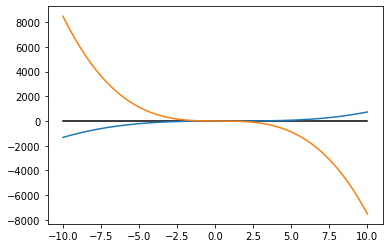

In [57]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)

plt.plot(x, x*0, "black")
plt.plot(x, cubic.forward(x))
plt.show()

In [58]:
# Display shape

cubic.forward(x).shape

TensorShape([500, 2])

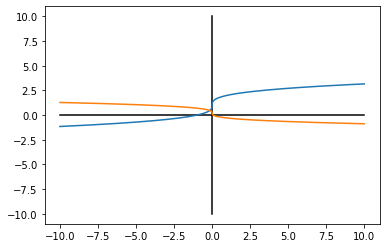

In [59]:
# Plot the inverse

plt.plot(x, x*0, "black")
plt.plot(x*0, x, "black")
plt.plot(x, cubic.inverse(x))
plt.show()

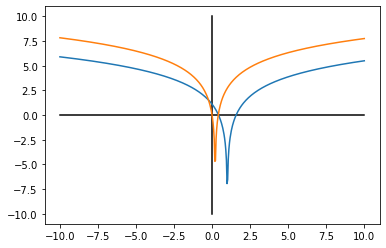

In [60]:
# Plot the forward log Jacobian determinant

plt.plot(x, x*0, "black")
plt.plot(x*0, x, "black")
plt.plot(x, cubic.forward_log_det_jacobian(x, event_ndims=0))
plt.show()

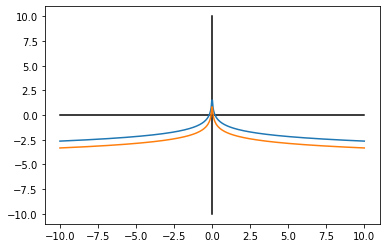

In [61]:
# Plot the inverse log Jacobian determinant

plt.plot(x, x*0, "black")
plt.plot(x*0, x, "black")
plt.plot(x, cubic.inverse_log_det_jacobian(x, event_ndims=0))
plt.show()

#### TransformedDistribution and plots

In [62]:
# Create a transformed distribution with Cubic

normal = tfd.Normal(loc=0, scale=2.0)

cubed_normal = tfd.TransformedDistribution(normal, cubic, event_shape=[2])

In [63]:
# Sample cubed_normal

g = cubed_normal.sample(10000)

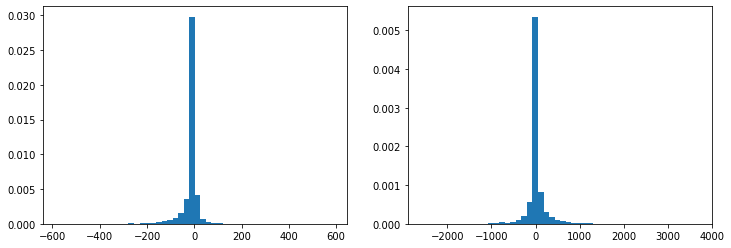

In [64]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

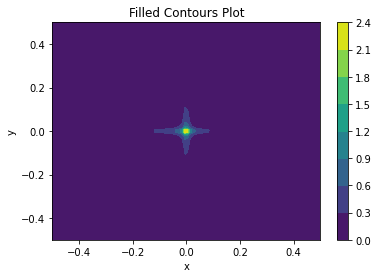

In [65]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [66]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
inv_cubed_normal = tfd.TransformedDistribution(normal, inverse_cubic, event_shape=[2])

In [67]:
# Samble inv_cubed_normal

g = inv_cubed_normal.sample(10000)

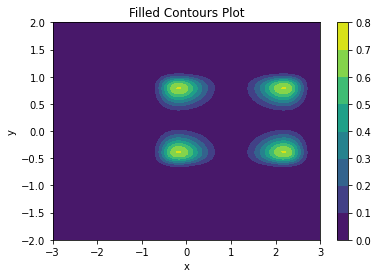

In [68]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

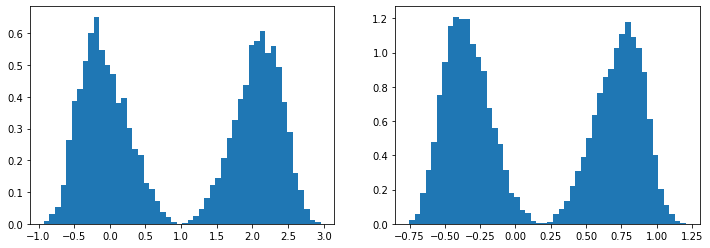

In [69]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

#### Training the bijector

In [70]:
# Create a mixture of four Gaussians

probs = [0.45, 0.55]

mix_gauss = tfd.Mixture(cat=tfd.Categorical(probs=probs), 
                        components = [
                                      tfd.Normal(loc=2.3, scale=0.4),
                                      tfd.Normal(loc=-0.8, scale=0.4)
                        ])

In [71]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

print(tf.data.experimental.cardinality(x_train))
print(tf.data.experimental.cardinality(x_valid))

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)
tf.Tensor(79, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)


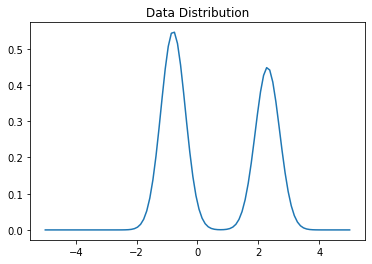

In [72]:
# Plot the data distribution

x = np.linspace(-5, 5, 100)

plt.plot(x, mix_gauss.prob(x))
plt.title("Data Distribution")
plt.show()

In [73]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25, dtype=tf.float32), tf.Variable(0.1, dtype=tf.float32)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.1>)

In [74]:
# Make a trainable transformed distribution

trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)

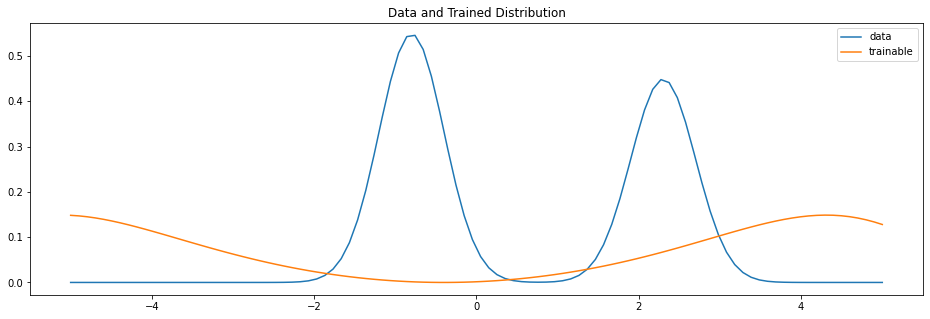

In [75]:
# Plot the data and learned distributions

x = np.linspace(-5, 5, 100)

plt.figure(figsize=(16, 5))
plt.plot(x, mix_gauss.prob(x), label="data")
plt.plot(x, trainable_dist.prob(x), label="trainable")
plt.title("Data and Trained Distribution")
plt.legend()

plt.show()

In [76]:
# Train the bijector

num_epochs = 20
opt = tf.keras.optimizers.Adam(learning_rate=0.5)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    print("Epoch: {:03d}\tLoss: {:0.12f}".format(epoch, tf.reduce_mean(loss)))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch: 000	Loss: 6.546390533447
Epoch: 001	Loss: 0.949966192245
Epoch: 002	Loss: 0.955630421638
Epoch: 003	Loss: 0.979508638382
Epoch: 004	Loss: 0.996122002602
Epoch: 005	Loss: 1.001795172691
Epoch: 006	Loss: 1.001498579979
Epoch: 007	Loss: 1.000610828400
Epoch: 008	Loss: 1.001842498779
Epoch: 009	Loss: 1.005323886871
Epoch: 010	Loss: 1.010428547859
Epoch: 011	Loss: 1.018343567848
Epoch: 012	Loss: 1.029785513878
Epoch: 013	Loss: 1.037849187851
Epoch: 014	Loss: 1.037697553635
Epoch: 015	Loss: 1.029961109161
Epoch: 016	Loss: 1.021343231201
Epoch: 017	Loss: 1.011975765228
Epoch: 018	Loss: 1.005620002747
Epoch: 019	Loss: 1.061805367470


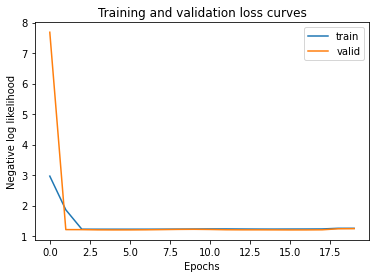

In [77]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

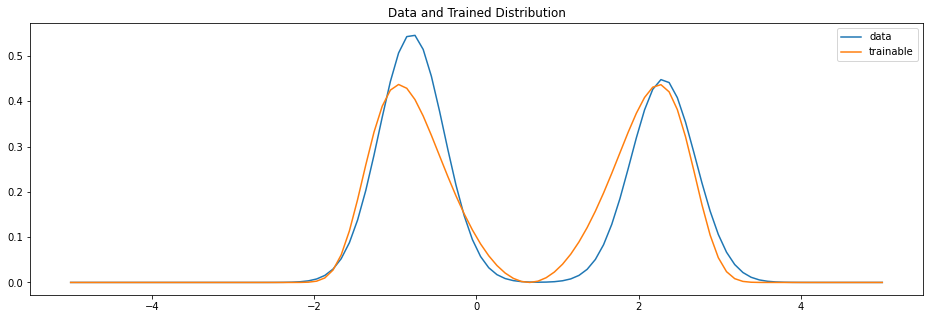

In [78]:
# Plot the data and learned distributions

x = np.linspace(-5, 5, 100)

plt.figure(figsize=(16, 5))
plt.plot(x, mix_gauss.prob(x), label="data")
plt.plot(x, trainable_dist.prob(x), label="trainable")
plt.title("Data and Trained Distribution")
plt.legend()

plt.show()

In [79]:
# Display trainable variables

trainable_dist.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.7351061>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.47703657>)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

In [ ]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

In [ ]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

In [ ]:
# Define base distribution



In [ ]:
# Define the trainable distribution



In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [ ]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

In [ ]:
# Plot contour



In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [ ]:
# Make samples



In [ ]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

In [ ]:
# Plot



#### Training a MaskedAutoregressiveFlow bijector

In [ ]:
from tensorflow.keras.callbacks import LambdaCallback

In [ ]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [ ]:
# Train the distribution



In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

In [ ]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples



In [ ]:
# Plot



In [ ]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

In [ ]:
# Plot contour



#### Training a chain of MaskedAutoregressiveFlow bijectors

In [ ]:
# Define a more expressive model



In [ ]:
# Define the trainable distribution



In [ ]:
# Make samples

def make_samples():
    x = base_distribution.sample((1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

In [ ]:
# Plot



In [ ]:
# Plot



In [ ]:
# Train the distribution



In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

In [ ]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples and plot



In [ ]:
# Plot



In [ ]:
# Plot

